In [ ]:
import glob
import pandas as pd
def get_log_props(log_path):
    parts = log_path.split('-')
    if len(parts) > 5:
        topic = parts[1]
        depth = parts[2].split('user')[-1]
        modality = parts[3]
        strat = parts[4]
        prob = parts[5].split(".")[0]

        return (topic, depth, modality, strat, prob)
    else:
        return 

corpus = "nyt"

log_root_path = "../example_sims/output_nyt/"

log_files = glob.glob(f"{log_root_path}{corpus}*.log")
topics = set()
depths = set()
modalities  = set()
strats = set()
probs = set()

log_cnt = 0

log_df = pd.DataFrame(columns=['Depth', 'Modality', 'Strat', 'Probability', 'Topics'])

for path in log_files:
    res = get_log_props(path)

    if res:
        log_cnt +=1
        topic, depth, modality, strat, prob = res
        topics.add(topic)
        depths.add(depth)
        modalities.add(modality)
        strats.add(strat)
        probs.add(prob)

        row = {'Depth' : depth, 'Modality': modality, 'Strat' : strat, 'Probability' : prob,  'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])


print(f"number of log files: {log_cnt}")


number of log files: 500


In [6]:
log_df.sort_values(by=["Depth"])

,Depth,Modality,Strat,Probability,Topics
0,307,llama,irreldocs,120td,bm25
0,307,llama,perfect,120td,bm25
0,307,llama,perfect_pre,120td,bm25
0,307,llama,contrastive,120td,bm25
0,307,llama,reldocs,120td,bm25
...,...,...,...,...,...
0,690,llama,minimal,120td,bm25
0,690,llama,perfect_pre,120td,bm25
0,690,llama,contrastive_no_trec,120td,bm25
0,690,llama,random,120td,bm25


# Evaluations

## Modalities

### sDCG 

In [7]:
topics = list(set([int(log.split('-')[2]) for log in log_files]))

In [8]:
topics_to_analyze = topics

In [ ]:
len(topics_to_analyze)

50

### Effort vs. Effect

## Depth evaluation

### sDCG

### Effort vs. Effect

/tmp/ipykernel_3563210/2045575477.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
/tmp/ipykernel_3563210/2045575477.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
/tmp/ipykernel_3563210/2045575477.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
/tmp/ipykernel_3563210/2045575477.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will ra

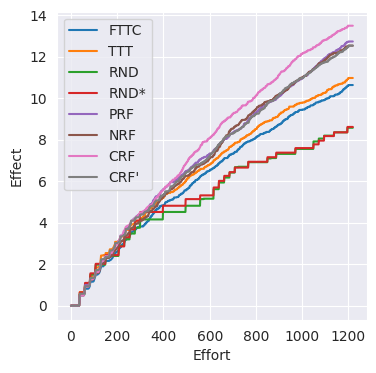

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os

sns.set_style('darkgrid')

qrels_path = f"{corpus}_qrels"

qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        #print(parts)
        #if parts[0] in topics_to_analyze:
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}

q_strats = ["llama"]
snippets = ["artificial", "minimal","random", "random_pre", "reldocs","irreldocs", "contrastive", "contrastive_no_trec"]
stop_decs = ['120td']
models = ['bm25']

depth_mapping = {
    'artificial': 'FTTC',
    'minimal': 'TTT',
    'random': 'RND',
    'random_pre' : 'RND*',
    'reldocs' : 'PRF',
    'irreldocs': 'NRF',
    'contrastive' : 'CRF',
    'contrastive_no_trec' : "CRF'",
}
q_strat = q_strats[0]
model = models[0]
stop_dec = stop_decs[0]
snippet = snippets[1]

depths = snippets

for depth in depths:

    for topic in topics_to_analyze:
        
        log_path = log_root_path + f"{corpus}" +"-"+ model + "-" + str(topic) + "-" + q_strat + "-"+ depth + "-"  + stop_dec+ ".log"
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}   
        with open(log_path) as f_in:
            for line in f_in.readlines():
                logs = line.split(' ')
                if len(logs) > 4 and logs[0] == 'ACTION':
                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].strip('\n')
                        
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    if True or int(logs[3]) < 300:
                        gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    adjusted_depth = depth_mapping.get(depth, depth)  
    depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'../figures/effort.effect.'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths) + "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()


['artificial', 'minimal', 'random', 'random_pre', 'reldocs', 'irreldocs', 'contrastive', 'contrastive_no_trec']


/tmp/ipykernel_3563210/3009309860.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
/tmp/ipykernel_3563210/3009309860.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
/tmp/ipykernel_3563210/3009309860.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
/tmp/ipykernel_3563210/3009309860.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will ra

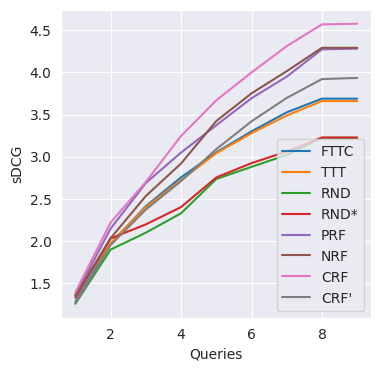

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = f"{corpus}_qrels"

qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

depth_eval = {}
gain_all = {}
print(depths)

for depth in depths:
    for topic in topics_to_analyze:

        log_path = log_root_path + f"{corpus}" +"-"+ model + "-" + str(topic) + "-" + q_strat + "-"+ depth + "-"  + stop_dec+ ".log"
        query_logs = {}

        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        gain = {}
        _gain = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _gain += dcg(results, topic) / (1 + math.log(q + 1, bq))
            gain[q+1] = _gain

        gain_all[topic] = gain
    adjusted_depth = depth_mapping.get(depth, depth)
    depth_eval[adjusted_depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))

aspects = [q_strat, model, stop_dec, corpus]
fig_name = f'../figures/sDCG.no_trec'
for aspect in aspects:
    if aspect not in depths:
        fig_name += f"{aspect}."
    else:
        fig_name += ".".join(depths)+ "."

fig_name += "pdf"
plt.savefig(fig_name, bbox_inches="tight") 
plt.show()